Loading data...
Preprocessing data...
Performing exploratory data analysis...


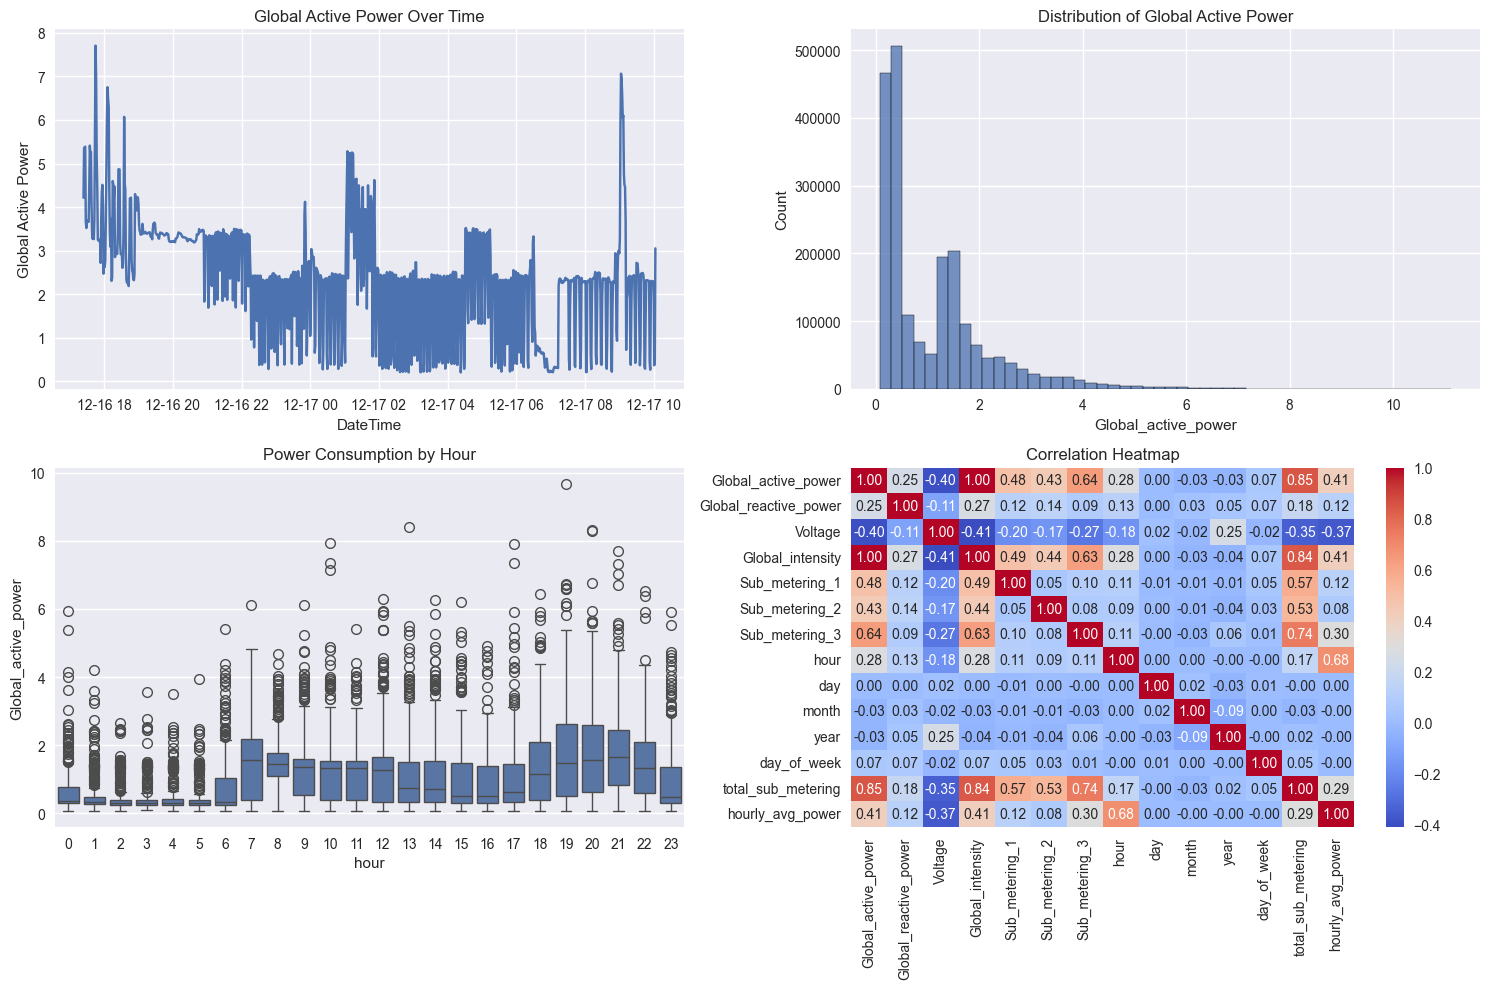

Preparing features...
Training and evaluating model...


In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
import warnings

warnings.filterwarnings('ignore')


# 1. Data Acquisition and Initial Setup
def load_data(filepath):
    """
    Load the household power consumption dataset
    """
    # Define column names
    columns = ['Date', 'Time', 'Global_active_power', 'Global_reactive_power',
               'Voltage', 'Global_intensity', 'Sub_metering_1',
               'Sub_metering_2', 'Sub_metering_3']

    # Read the data with semi-colon separator and specified column names
    df = pd.read_csv(filepath, sep=';', names=columns, na_values=['?'])

    # Parse datetime explicitly
    df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], errors='coerce', dayfirst=True)

    # Drop rows where datetime conversion failed
    df = df.dropna(subset=['datetime'])

    # Convert power consumption columns to numeric, setting errors='coerce' to handle non-numeric entries
    cols_to_numeric = ['Global_active_power', 'Global_reactive_power', 'Voltage',
                       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
    for col in cols_to_numeric:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # Drop any remaining rows with NaN values after conversion
    df = df.dropna()

    return df


# 2. Data Cleaning and Preprocessing
def preprocess_data(df):
    """
    Clean and preprocess the dataset
    """
    # Extract time-based features
    df['hour'] = df['datetime'].dt.hour
    df['day'] = df['datetime'].dt.day
    df['month'] = df['datetime'].dt.month
    df['year'] = df['datetime'].dt.year
    df['day_of_week'] = df['datetime'].dt.dayofweek

    # Create aggregate features
    df['total_sub_metering'] = (df['Sub_metering_1'] +
                                df['Sub_metering_2'] +
                                df['Sub_metering_3'])

    # Calculate hourly averages
    df['hourly_avg_power'] = df.groupby('hour')['Global_active_power'].transform('mean')

    return df


# 3. Exploratory Data Analysis
def perform_eda(df):
    """
    Perform exploratory data analysis and create visualizations
    """
    # Set up the plotting style
    plt.style.use('seaborn-v0_8')

    # Create multiple visualizations
    fig = plt.figure(figsize=(15, 10))

    # 1. Time series plot of global active power
    plt.subplot(2, 2, 1)
    plt.plot(df['datetime'][:1000], df['Global_active_power'][:1000])
    plt.title('Global Active Power Over Time')
    plt.xlabel('DateTime')
    plt.ylabel('Global Active Power')

    # 2. Distribution of global active power
    plt.subplot(2, 2, 2)
    sns.histplot(df['Global_active_power'], bins=50)
    plt.title('Distribution of Global Active Power')

    # 3. Box plot of power consumption by hour
    plt.subplot(2, 2, 3)
    sns.boxplot(x='hour', y='Global_active_power', data=df.sample(10000))
    plt.title('Power Consumption by Hour')

    # 4. Correlation heatmap
    plt.subplot(2, 2, 4)
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Heatmap')

    plt.tight_layout()
    plt.show()

    return fig


# 4. Feature Engineering and Model Preparation
def prepare_features(df):
    """
    Prepare features for model training
    """
    # Select features for modeling
    feature_columns = ['hour', 'day', 'month', 'year', 'day_of_week',
                       'Global_reactive_power', 'Voltage', 'Global_intensity',
                       'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3',
                       'hourly_avg_power']

    X = df[feature_columns]
    y = df['Global_active_power']

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                        random_state=42)

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled, y_train, y_test, scaler


# 5. Model Training and Evaluation
def train_and_evaluate_model(X_train, X_test, y_train, y_test):
    """
    Train and evaluate the Random Forest model
    """
    # Initialize the model
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

    # Define parameter grid for GridSearchCV
    param_grid = {
        'n_estimators': [50, 100],
        'max_depth': [10, 20],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    }

    # Perform GridSearchCV
    grid_search = GridSearchCV(rf_model, param_grid, cv=3,
                               scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)

    # Get best model
    best_model = grid_search.best_estimator_

    # Make predictions
    y_pred = best_model.predict(X_test)

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Print results
    print("\nModel Performance Metrics:")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R2 Score: {r2:.4f}")

    return best_model, y_pred


# 6. Feature Importance Analysis
def analyze_feature_importance(model, feature_columns):
    """
    Analyze and visualize feature importance
    """
    # Get feature importance
    importance = model.feature_importances_

    # Create DataFrame of features and their importance
    feature_imp = pd.DataFrame({'feature': feature_columns,
                                'importance': importance})
    feature_imp = feature_imp.sort_values('importance', ascending=False)

    # Plot feature importance
    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=feature_imp)
    plt.title('Feature Importance in Predicting Energy Consumption')
    plt.show()

    return feature_imp


# 7. Deployment Functions
def make_predictions(model, scaler, new_data):
    """
    Make predictions on new data
    """
    # Preprocess new data
    scaled_data = scaler.transform(new_data)

    # Make predictions
    predictions = model.predict(scaled_data)

    return predictions


# Main execution function
def main():
    """
    Main function to run the entire pipeline
    """
    # 1. Load data
    print("Loading data...")
    df = load_data('household_power_consumption.txt')

    # 2. Preprocess data
    print("Preprocessing data...")
    df_processed = preprocess_data(df)

    # 3. Perform EDA
    print("Performing exploratory data analysis...")
    perform_eda(df_processed)

    # 4. Prepare features
    print("Preparing features...")
    X_train, X_test, y_train, y_test, scaler = prepare_features(df_processed)

    # 5. Train and evaluate model
    print("Training and evaluating model...")
    model, predictions = train_and_evaluate_model(X_train, X_test, y_train, y_test)

    # 6. Analyze feature importance
    print("Analyzing feature importance...")
    feature_columns = ['hour', 'day', 'month', 'year', 'day_of_week',
                       'Global_reactive_power', 'Voltage', 'Global_intensity',
                       'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3',
                       'hourly_avg_power']
    feature_importance = analyze_feature_importance(model, feature_columns)

    return model, scaler


if __name__ == "__main__":
    main()
